### Dataset [Retinal OCT Images](https://www.kaggle.com/paultimothymooney/kermany2018) on Kaggle.
- Cell paper: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
- paper data source: https://data.mendeley.com/datasets/rscbjbr9sj/2


### Section 1: Check data balance and quick look at the images
- visualize random samples in the dataset
- check sample distribution
- handle the imbalanced training samples by using class_weight

### Section 2: Load in pretrained model
- define pretrained models: VGG19, InceptionV3 and ResNet50 pretrained with imgnet. (keras applications)
- remove fully-connected layers and add our own dense layers

### Section 3: Quick comparison of pretrained models
- compare rough performance of the two pretrained models on the dataset
- using generator to convert grayscale to rgb and to feed data to model at the same time
    
### Section 4: Training for more epochs
- improve performance by adding lr reduction and increasing epochs

### Section 5: Confusion matrix and conclusion


# Import packages

In [1]:
import glob
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix

from keras import backend as K
# K.set_image_data_format("channels_last") # make sure models take input_shape (samples, height, width, channels)

%matplotlib inline

Using TensorFlow backend.


# Section 1: Check data balance and quick look at the images

### Section 1.1: Selection random 4 images from each group

In [2]:
def random_training_samples():

    """
    showing 4 examples from each conditions ["CNV", "DME", "DRUSEN", "NORMAL"] in the training set
    return a matplotlib figure
    """

    conditions = ["CNV", "DME", "DRUSEN", "NORMAL"]
    show_lst = []
    for condition in conditions:

        path = f"./dataset/OCT2017/train/{condition}/"
        # list all jpeg files in the folder
        # element in the list has full file path, eg. './dataset/OCT2017/train/CNV/CNV-1016042-1.jpeg'
        f_lst = glob.glob(f"{path}*.jpeg")

        # pick random 4 images, combine sample_lst to show_list
        sample_lst = random.sample(f_lst, k=4)
        show_lst += sample_lst

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    for f, ax in zip(show_lst, axes.flat):
        img = cv2.imread(f"{f}")
        ax.imshow(img)

    for c, n in zip(conditions, range(4)):
        plt.annotate(
            c,
            (0.95, 0.875 - n * 0.25),
            xycoords="figure fraction",
            fontsize=14,
            ha="center",
        )

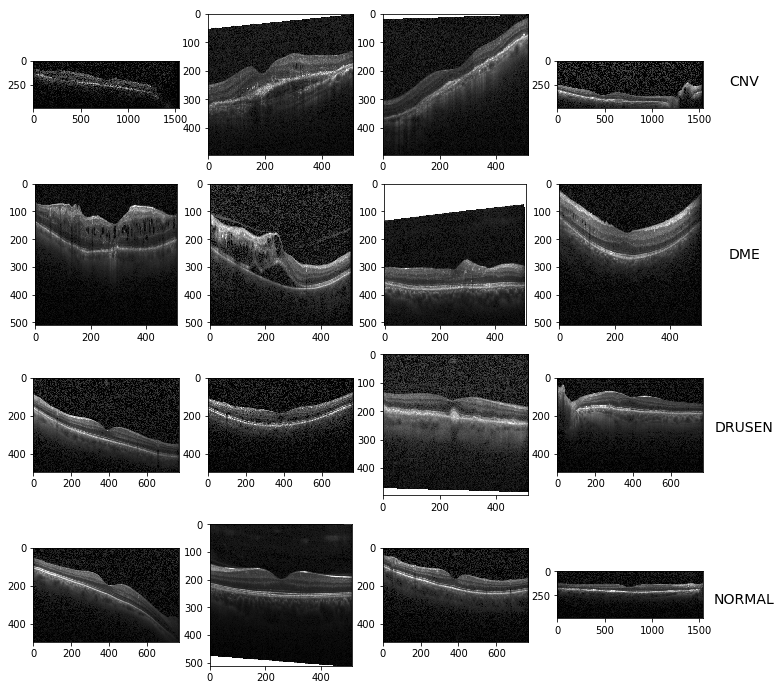

In [3]:
# show random 4 images from each group ["CNV", "DME", "DRUSEN", "NORMAL"] in the training set
random_training_samples()

### Section 1.2: check number of training samples in each group

In [4]:
# Data distribution

train_folder = "./dataset/OCT2017/train/"
val_folder = "./dataset/OCT2017/val/"
test_folder = "./dataset/OCT2017/test/"

conditions = ["CNV", "DME", "DRUSEN", "NORMAL"]
folders = [train_folder, val_folder, test_folder]

# get number of images in subfolders, return lists of tuples (condition, number of images)
training_images = [] 
test_images = []
val_images = []
for folder, lst in zip(folders, [training_images, val_images, test_images]):
        for condition in conditions:
            path = f"{folder}{condition}/"
            nb_img = len(glob.glob(f"{path}*.jpeg")) 
            lst.append(nb_img)

# Visualize data distribution in DataFrame 

data_distro = pd.DataFrame({
    "Train": [c for c in training_images],
    "Val": [c for c in val_images],
    "Test": [c for c in test_images]}, index=conditions)

data_distro

,Train,Val,Test
CNV,37205,8,242
DME,11348,8,242
DRUSEN,8616,8,242
NORMAL,26315,8,242


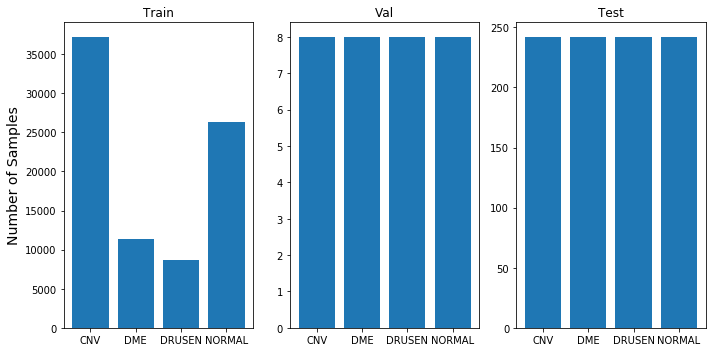

In [5]:
# Visualize data distribution with bar charts

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for col, ax in zip(data_distro.columns, axes.flat):
    x = data_distro.index
    ax.bar(x, data_distro[col])
    ax.set_title(col)
axes.flat[0].set_ylabel("Number of Samples", fontsize=14)

fig.tight_layout()

### Section 1.3: handle imbalanced sample sizes with keras argument class_weight

In [6]:
# get approximate ratios between conditions, and put into a dict 

# add a column call Train_ratio
data_distro["Train_ratio"] = 1 / data_distro["Train"].div(data_distro["Train"].max())
# add a column categorical label
data_distro["cat_label"] = np.arange(0,4,1)

# to_dict() funcion puts a pandas series into a dict
class_weight = data_distro.set_index("cat_label")["Train_ratio"].to_dict()

# the dictionary class_weight will be passed into fit_generator() function
print(f"class_weight is a {type(class_weight)}: {class_weight}")

data_distro

class_weight is a <class 'dict'>: {0: 1.0, 1: 3.278551286570321, 2: 4.3181290622098425, 3: 1.4138324149724493}


,Train,Val,Test,Train_ratio,cat_label
CNV,37205,8,242,1.000000,0
DME,11348,8,242,3.278551,1
DRUSEN,8616,8,242,4.318129,2
NORMAL,26315,8,242,1.413832,3


# Section 2: Define Model

In [7]:
def pretrained_model(base, imsize):
    
    """
    base, string, "VGG19", "InceptionV3", "ResNet50"
    imsize, int, for input_shape to base model. All images will be resized before being fed into model
    return modified model
    """
    
    if base == "InceptionV3":
        base_model = InceptionV3(weights='imagenet', include_top=False, pooling="avg", input_shape=(imsize, imsize, 3))
        X = base_model.output            
        
    elif base == "VGG19":
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(imsize, imsize, 3))
        X = base_model.output
        X = Conv2D(512, kernel_size = (4,4), strides=(4,4), padding = 'valid')(X)
        X = Flatten()(X)
        
    elif base =="ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(imsize, imsize, 3))
        X = base_model.output
    
    X = BatchNormalization()(X)
    
    X = Dense(512, activation="relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

# Extra one or two layers here showed min effect on performance. Pretrained models are very good already
#     X = Dense(256, activation="relu")(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.5)(X)

#     X = Dense(64, activation="relu")(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.5)(X)
    
    predictions = Dense(4, activation="softmax")(X)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model
    

# Section 3: Quick comparison of pretrained models

### Section 3.1: Prepare data using generators

In [8]:
# use generator to feed data
# fit_generator is very helpful whenever the dataset is large

total_train_img = data_distro["Train"].sum()            # total number of training samples
total_val_img = data_distro["Val"].sum()            # total number of val samples
total_test_img = data_distro["Test"].sum()            # total number of testing samples

# how many images are generated and passed to model per step
train_BS = 64            # train generator batch size 
val_BS = 4            # train generator batch size
test_BS = 22           # train generator batch size, so that (total_test_img % test_BS) == 0

imsize=256        # all images will be resize to (256, 256) by the generator

datagen = ImageDataGenerator(rescale=1/255)            # rescale image from 0-255 to 0-1

train_generator = datagen.flow_from_directory(
    directory = train_folder,
    classes = conditions,
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = train_BS,
    target_size=(imsize, imsize))

val_generator = datagen.flow_from_directory(
    directory = val_folder,
    classes = conditions,
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = val_BS,
    target_size=(imsize, imsize))

# set the shuffle to False, so that it's easier to track the labels and predicitons for confusion matrix
test_generator = datagen.flow_from_directory(
    directory = test_folder,
    classes = conditions,
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = test_BS,
    shuffle = False, 
    target_size=(imsize, imsize))


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [9]:
histories = {}
evaluates = {}

imsize = 256

for base in ["InceptionV3", "ResNet50", "VGG19"]:
    
    print(base)
    
    model = pretrained_model(base, imsize)
    opt = Adam() # use default for quick comparison, no callbacks either
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    histories[base] = model.fit_generator(
        train_generator,
        steps_per_epoch= (total_train_img // train_BS),
        epochs=15,
        validation_data = val_generator,
        validation_steps = (total_val_img // val_BS),
        class_weight=class_weight
    )
    
    
    evaluates[base] = model.evaluate_generator(
        test_generator, 
        steps = (total_test_img // test_BS)
    )
        
    print("\n")

W0916 22:00:44.474275  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 22:00:44.485258  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 22:00:44.487241  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 22:00:44.507166  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0916 22:00:44.507166  4

InceptionV3


W0916 22:00:45.451935  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0916 22:00:45.637461  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0916 22:00:46.237856  4204 deprecation_wrapper.py:119] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0916 22:00:55.150108  4204 deprecation.py:506] From C:\Users\josta\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions fo

Epoch 1/15
1304/1304 [==============================] - 232s 178ms/step - loss: 1.4591 - acc: 0.7208 - val_loss: 1.1789 - val_acc: 0.4688
Epoch 2/15
1304/1304 [==============================] - 229s 176ms/step - loss: 1.1445 - acc: 0.7658 - val_loss: 1.7023 - val_acc: 0.4062
Epoch 3/15
1304/1304 [==============================] - 229s 175ms/step - loss: 1.0760 - acc: 0.7781 - val_loss: 1.8538 - val_acc: 0.3750
Epoch 4/15
1304/1304 [==============================] - 229s 176ms/step - loss: 1.0306 - acc: 0.7872 - val_loss: 1.5063 - val_acc: 0.5312
Epoch 5/15
1304/1304 [==============================] - 229s 176ms/step - loss: 0.9896 - acc: 0.7949 - val_loss: 2.3830 - val_acc: 0.3438
Epoch 6/15
1304/1304 [==============================] - 227s 174ms/step - loss: 0.9409 - acc: 0.8075 - val_loss: 2.3001 - val_acc: 0.3750
Epoch 7/15
1304/1304 [==============================] - 229s 175ms/step - loss: 0.9093 - acc: 0.8112 - val_loss: 2.1990 - val_acc: 0.4375
Epoch 8/15
1304/1304 [============

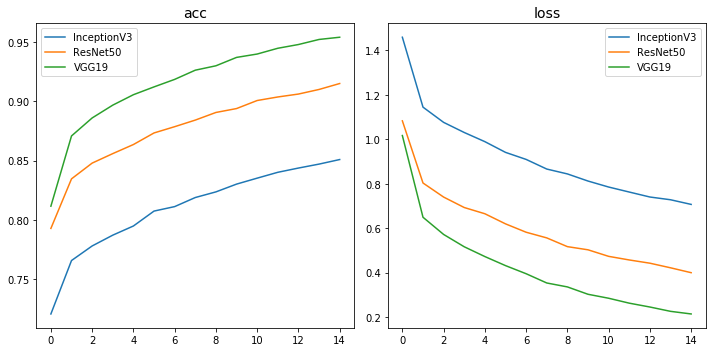

In [10]:
Comp, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for base in histories.keys():
    for metric, ax in zip(["acc", "loss"], axes.flat):
        ax.plot(histories[base].history[metric], label=base)
        ax.set_title(metric, fontsize=14)
        ax.legend()
Comp.tight_layout()
Comp.savefig("model_comp.png", dpi=150)

# Section 4: Training for more epochs

In [11]:
# clean computation graphs
from keras import backend as K
K.clear_session()

train_generator.reset()
test_generator.reset()

# iterate 50 epoch and 
vgg19 = pretrained_model("VGG19", 256)

# introduce lr decay and a callback on lr reduction
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-4, min_delta=1e-3, verbose=1)
opt = Adam()
vgg19.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

vgg19_history = vgg19.fit_generator(
    train_generator,
    steps_per_epoch=(total_train_img // train_BS),
    epochs=30,
    validation_data = test_generator,
    validation_steps = (total_test_img // test_BS),
    class_weight=class_weight,
    callbacks=[lr_reduction]
)

Epoch 1/30
1304/1304 [==============================] - 482s 370ms/step - loss: 1.0285 - acc: 0.8080 - val_loss: 0.1369 - val_acc: 0.9566
Epoch 2/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.6598 - acc: 0.8694 - val_loss: 0.1928 - val_acc: 0.9318
Epoch 3/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.5752 - acc: 0.8851 - val_loss: 0.4193 - val_acc: 0.8254
Epoch 4/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.5186 - acc: 0.8959 - val_loss: 0.1796 - val_acc: 0.9339

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.3861 - acc: 0.9210 - val_loss: 0.0858 - val_acc: 0.9669
Epoch 6/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.3550 - acc: 0.9275 - val_loss: 0.1669 - val_acc: 0.9504
Epoch 7/30
1304/1304 [==============================] - 480s 368ms/step - loss: 0.3205 - ac

[(-2, 32), Text(0.5, 1.0, 'Loss')]

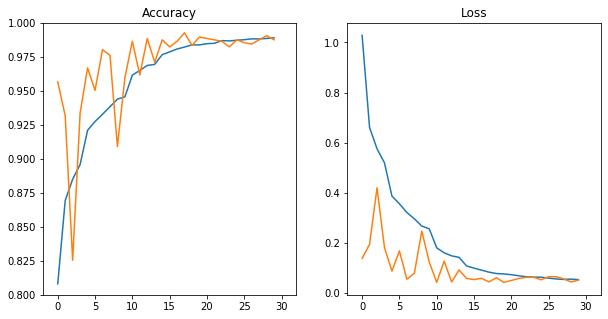

In [18]:
vgg_df = pd.DataFrame(vgg19_history.history)

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)

axes[0].plot(vgg_df["acc"], label="training acc")
axes[0].plot(vgg_df["val_acc"], label="val acc")
axes[0].set(title="Accuracy", xlim=(-2,32), ylim=(0.8,1))

axes[1].plot(vgg_df["loss"])
axes[1].plot(vgg_df["val_loss"], label="val_loss")
axes[1].set(title="Loss", xlim=(-2,32))



# Section 5: Confusion matrix and conclusion

In [13]:
# reset the generator before prediction
test_generator.reset()

# get predictions 
pred = vgg19.predict_generator(
    test_generator,
    steps = (total_test_img // test_BS)
)
 
pred = np.argmax(pred, axis=-1) # 1D array of predicting classes
label = test_generator.classes # 1D array of label classes

print (test_generator.class_indices) # get categorical reference

# make sure the prediction and label have the same shape
pred.shape, label.shape

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


((968,), (968,))

In [23]:
# use sklearn to generate confusion matrix
confusion = confusion_matrix(label, pred)
confusion = pd.DataFrame(confusion, columns=[f"Pred_{c}" for c in conditions], index=conditions)
confusion

,Pred_CNV,Pred_DME,Pred_DRUSEN,Pred_NORMAL
CNV,242,0,0,0
DME,3,232,1,6
DRUSEN,1,0,241,0
NORMAL,0,0,1,241


In [15]:
# vgg19.save("vgg19.h5")